In [1]:
%load_ext autotime
from  utils import *
from pylab import save, load
seed = 5757

In [11]:
write_mura_data_preprocess(data_path = 'data/MURA-v1.1',
                                                bone_name = 'ALL',sample = 'train',target_size=(224,224))

INFO:utils.mura_utils:reading all images from train
100% (36808 of 36808) |##################| Elapsed Time: 0:23:56 Time:  0:23:56
INFO:utils.mura_utils:writing x_pickcle finishes
INFO:utils.mura_utils:writing y_pickle finishes


time: 28min 4s


In [9]:
write_mura_data_preprocess(data_path = 'data/MURA-v1.1',   
                                                bone_name = 'ALL',sample = 'valid',target_size=(224,224))

INFO:utils.mura_utils:reading all images from valid
100% (3197 of 3197) |####################| Elapsed Time: 0:01:56 Time:  0:01:56
INFO:utils.mura_utils:writing x_pickcle finishes
INFO:utils.mura_utils:writing y_pickle finishes


time: 2min 19s


In [2]:
x_train, y_train = read_mura_data_preprocess(data_path = 'data/MURA-v1.1', sample = 'train', bone_name = "ALL")

INFO:utils.mura_utils:ALL and ALL exist, load directly


time: 3min 17s


In [3]:
x_test, y_test = read_mura_data_preprocess(data_path = 'data/MURA-v1.1', sample = 'valid', bone_name = "ALL")

INFO:utils.mura_utils:ALL and ALL exist, load directly


time: 17.7 s


In [5]:
x_train.shape

(36808, 224, 224, 3)

time: 7.47 ms


In [6]:
x_test.shape, y_test.shape

((3197, 224, 224, 3), (3197,))

time: 11.6 ms


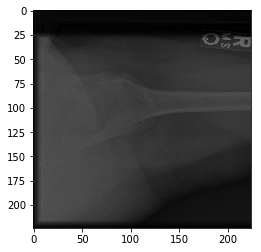

time: 373 ms


In [15]:
import matplotlib.pyplot as plt
%matplotlib inline
 
plt.imshow(x_train[0], cmap=plt.cm.binary)

In [7]:
from keras.applications.densenet import DenseNet169
from keras.preprocessing import image
from keras.applications.resnet50 import preprocess_input, decode_predictions
import numpy as np
from keras.layers import Dense, Dropout, Activation, Flatten,GlobalAveragePooling2D
from keras.models import Model
from keras.utils import np_utils



Using TensorFlow backend.


time: 5.98 s


In [8]:
height, width = (224,224)

time: 891 µs


In [9]:
x_train = x_train.reshape(x_train.shape[0], height, width, 3)
x_test  = x_test.reshape(x_test.shape[0],height,width, 3)
y_train = np_utils.to_categorical(y_train)
y_test  = np_utils.to_categorical(y_test)



time: 3.62 ms


In [10]:
from sklearn.model_selection import train_test_split

x_train, x_valid, y_train, y_valid = train_test_split(x_train,y_train, 
                                                      test_size = 0.1, shuffle = True, random_state = seed )




time: 59.5 s


In [11]:
x_train.shape, x_valid.shape

((33127, 224, 224, 3), (3681, 224, 224, 3))

time: 10.7 ms


In [12]:
from keras.preprocessing.image import ImageDataGenerator
train_generator = ImageDataGenerator(rotation_range=10,
                                horizontal_flip=True)
                                #vertical_flip=True)
    
valid_generator = ImageDataGenerator(
                                rotation_range=10,
                                horizontal_flip=True)
                                #vertical_flip=True)
    
#datagen.fit(x_train)

time: 3.11 ms


In [ ]:
#adam = optimizers.Adam(amsgrad=False) #try true later


In [14]:
batch_size  = 64
epochs = 20 

base_model = DenseNet169(input_shape=(224,224,3),weights="data/densenet169_weights_tf_dim_ordering_tf_kernels_notop.h5", include_top=False)
x = base_model.output
x = GlobalAveragePooling2D()(x)


#x = Flatten()(x)
x = Dense(128, activation='relu')(x)
preds = Dense(2, activation='softmax')(x)

model = Model(base_model.input, preds)
# and a logistic layer -- let's say we have 200 classes, sigmoid for binary, softmax for multiple classes
predictions = Dense(2, activation='sigmoid')(x)



time: 1min 8s


In [16]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(train_generator.flow(x_train, y_train), 
                    steps_per_epoch = len(x_train) / batch_size, 
                    validation_data = valid_generator.flow(x_valid,y_valid),
                    validation_steps = len(x_valid) / batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/20
518/517 [==============================] - 244s 471ms/step - loss: 0.5761 - val_loss: 0.8857
Epoch 2/20
518/517 [==============================] - 226s 435ms/step - loss: 0.5397 - val_loss: 0.8697
Epoch 3/20
518/517 [==============================] - 227s 438ms/step - loss: 0.5182 - val_loss: 0.8753
Epoch 4/20
518/517 [==============================] - 225s 434ms/step - loss: 0.5101 - val_loss: 0.8658
Epoch 5/20
518/517 [==============================] - 226s 436ms/step - loss: 0.4963 - val_loss: 0.9791
Epoch 6/20
518/517 [==============================] - 226s 437ms/step - loss: 0.4979 - val_loss: 1.1929
Epoch 7/20
518/517 [==============================] - 226s 437ms/step - loss: 0.4811 - val_loss: 0.9515
Epoch 8/20
518/517 [==============================] - 226s 435ms/step - loss: 0.4849 - val_loss: 1.1190
Epoch 9/20
518/517 [==============================] - 225s 435ms/step - loss: 0.4740 - val_loss: 1.1637
Epoch 10/20
518/517 [==============================] - 226s 437m

time: 1h 16min 12s


In [17]:
model.save(filepath='trained_models/2_1_DenseNet169_trained_wrist_20.h5',overwrite=True)

time: 1min 13s


In [ ]:
# this is the model we will train
model = Model(inputs=base_model.input, outputs=predictions)

# first: train only the top layers (which were randomly initialized)
# i.e. freeze all convolutional InceptionV3 layers
for layer in base_model.layers:
    layer.trainable = False

# compile the model (should be done *after* setting layers to non-trainable)
model.compile(optimizer='rmsprop', loss='categorical_crossentropy')

# train the model on the new data for a few epochs
model.fit_generator(train_generator.flow(x_train, y_train), 
                    steps_per_epoch = len(x_train) / batch_size, 
                    validation_data = valid_generator.flow(x_valid,y_valid),
                    validation_steps = len(x_valid) / batch_size,
                    epochs=epochs, verbose=1)

Epoch 1/20
518/517 [==============================] - 261s 503ms/step - loss: 0.4483 - val_loss: 1.1976
Epoch 2/20
518/517 [==============================] - 244s 471ms/step - loss: 0.4551 - val_loss: 1.1262
Epoch 3/20
518/517 [==============================] - 245s 474ms/step - loss: 0.4434 - val_loss: 1.4114
Epoch 4/20
518/517 [==============================] - 246s 474ms/step - loss: 0.4602 - val_loss: 1.2579
Epoch 5/20
518/517 [==============================] - 245s 474ms/step - loss: 0.4450 - val_loss: 1.5337
Epoch 6/20
518/517 [==============================] - 247s 476ms/step - loss: 0.4488 - val_loss: 1.1809
Epoch 7/20
518/517 [==============================] - 245s 474ms/step - loss: 0.4440 - val_loss: 1.5550
Epoch 8/20
518/517 [==============================] - 245s 474ms/step - loss: 0.4481 - val_loss: 1.4517
Epoch 9/20
518/517 [==============================] - 247s 476ms/step - loss: 0.4449 - val_loss: 1.5146
Epoch 10/20
518/517 [==============================] - 246s 476m

In [ ]:
model.save(filepath='trained_models/2_1_DenseNet169_trained_wrist_40.h5',overwrite=True)

In [ ]:
model.compile(loss='categorical_crossentropy',
              optimizer= 'adam',
              metrics=['accuracy'])
model.fit_generator(datagen.flow(x_train, y_train, batch_size=8), 
                    steps_per_epoch = len(x_train) / 8, epochs=50, verbose=2)

In [ ]:
model.save('./trained_models/1_3_densenet201_mura.h5')

In [ ]:
model.summary()
# Start Fine-tuning
model.fit(X_train, Y_train,batch_size=batch_size,epochs=nb_epoch,shuffle=True,verbose=1,validation_data=(X_valid, Y_valid))

# Make predictions
predictions_valid = model.predict(X_valid, batch_size=batch_size, verbose=1)

In [ ]:
# here's a more "manual" example
for e in range(epochs):
    print('Epoch', e)
    batches = 0
    for x_batch, y_batch in datagen.flow(x_train, y_train, batch_size=32):
        model.fit(x_batch, y_batch)
        batches += 1
        if batches >= len(x_train) / 32:
            # we need to break the loop by hand because
            # the generator loops indefinitely
            break